# MNIST convolutional neural networks with regularization

* Make a networks like LeNet5 structure with MNIST data
* input pipeline: `tf.data`
* `Eager execution`
* `Functional API`
* Apply various regularization methods

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/multi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape([-1, 28, 28, 1])
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape([-1, 28, 28, 1])
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

### Show the MNIST

label = 5


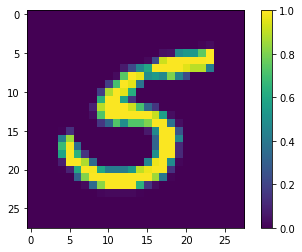

In [3]:
index = 219
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index][...,0])
plt.colorbar()
#plt.gca().grid(False)
plt.show()

## Set up dataset with `tf.data`

### input pipeline `tf.data.Dataset` and Transformation

In [4]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.batch(batch_size = batch_size)
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>


## Create the model

* Use `tf.keras.layers`

* Use `tf.keras.Sequential()` API (01.mnist.LeNet5.ipynb)
```python
model = tf.keras.Sequential([
  layers.Conv2D(filters=32, kernel_size=[5, 5], padding='same', activation='relu'),
  layers.MaxPool2D(),
  layers.Conv2D(filters=64, kernel_size=[5, 5], padding='same', activation='relu'),
  layers.MaxPool2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(10)])```

In [5]:
class MNISTModel(tf.keras.Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.l2_decay = 0.001
    self.conv1 = layers.Conv2D(filters=32, kernel_size=[5, 5], padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(self.l2_decay))
    self.conv1_bn = layers.BatchNormalization()
    self.pool1 = layers.MaxPool2D()
    self.conv2 = layers.Conv2D(filters=64, kernel_size=[5, 5], padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(self.l2_decay))
    self.conv2_bn = layers.BatchNormalization()
    self.pool2 = layers.MaxPool2D()
    self.flatten = layers.Flatten()
    self.dense1 = layers.Dense(units=1024,
                               kernel_regularizer=tf.keras.regularizers.l2(self.l2_decay))
    self.dense1_bn = layers.BatchNormalization()
    self.drop1 = layers.Dropout(rate=0.6)
    self.dense2 = layers.Dense(units=10, kernel_regularizer=tf.keras.regularizers.l2(self.l2_decay))

  def call(self, inputs, training=True):
    """Run the model."""
    self.conv1_ = self.conv1(inputs)
    self.conv1_bn_ = self.conv1_bn(self.conv1_, training=training)
    self.conv1_ = tf.nn.relu(self.conv1_bn_)
    self.pool1_ = self.pool1(self.conv1_)
    
    self.conv2_ = self.conv2(self.pool1_)
    self.conv2_bn_ = self.conv2_bn(self.conv2_, training=training)
    self.conv2_ = tf.nn.relu(self.conv2_bn_)
    self.pool2_ = self.pool2(self.conv2_)
    
    self.flatten_ = self.flatten(self.pool2_)
    self.dense1_ = self.dense1(self.flatten_)
    self.dense1_bn_ = self.dense1_bn(self.dense1_, training=training)
    self.dense1_ = tf.nn.relu(self.dense1_bn_)
    self.drop1_ = self.drop1(self.dense1_, training=training)
    self.logits_ = self.dense2(self.drop1_)
    
    return self.logits_

In [6]:
model = MNISTModel()

In [7]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  print("Logits: ", model(images[0:3], training=False).shape)

Logits:  (3, 10)


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  832       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51264     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
__________

## Train a model

### Define a optimizer

In [9]:
optimizer = tf.train.AdamOptimizer(1e-4)
cross_entropy_history = []
l2_loss_history = []
total_loss_history = []

### Train a model

In [10]:
global_step = tf.train.get_or_create_global_step()
for epoch in range(max_epochs):
  for images, labels in train_dataset:
    start_time = time.time()
    with tf.GradientTape() as tape:
      logits = model(images, training=True)
      cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels, logits)
      l2_loss = tf.reduce_sum(model.losses)
      total_loss = cross_entropy + l2_loss

    cross_entropy_history.append(cross_entropy.numpy())
    l2_loss_history.append(l2_loss.numpy())
    total_loss_history.append(total_loss.numpy())
    
    grads = tape.gradient(total_loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=global_step)

    if global_step.numpy() % 10 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * global_step.numpy() / float(len(train_data))
      print("epochs: {:.2f}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs, global_step.numpy(), total_loss, examples_per_sec, duration))

print("training done!")

epochs: 1.00, step: 1870, loss: 1.06181, (247.83 examples/sec; 0.129 sec/batch)
training done!


### Plot the loss funtion

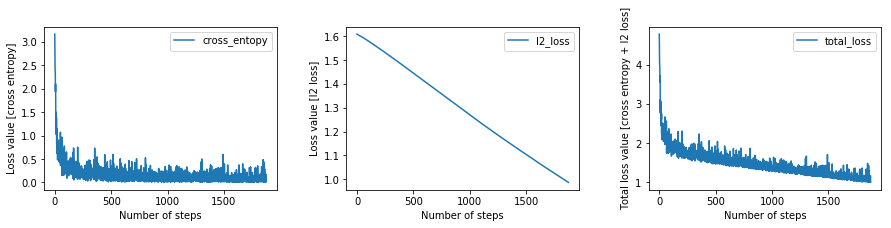

In [11]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
#plt.set_title("cross_entropy")
plt.plot(cross_entropy_history, label='cross_entopy')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()

plt.subplot(1, 3, 2)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
#plt.set_title("l2_loss")
plt.plot(l2_loss_history, label='l2_loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [l2 loss]')
plt.legend()

plt.subplot(1, 3, 3)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
#plt.set_title("total_loss")
plt.plot(total_loss_history, label='total_loss')
plt.xlabel('Number of steps')
plt.ylabel('Total loss value [cross entropy + l2 loss]')
plt.legend()

plt.show()

## Evaluate a model

### Test trained model

* test accuracy: 0.9798 for 1 epochs (without regularization)
* test accuracy: 0.9869 for 1 epochs (with regularization)

In [12]:
accuracy = tf.contrib.eager.metrics.Accuracy()

for images, labels in test_dataset:
  logits = model(images, training=False)
  accuracy(labels=labels, predictions=tf.cast(tf.argmax(logits, 1), tf.int32))
  
print("test accuracy: {}".format(accuracy.result()))

test accuracy: 0.9876


### Plot test set

In [13]:
np.random.seed(219)

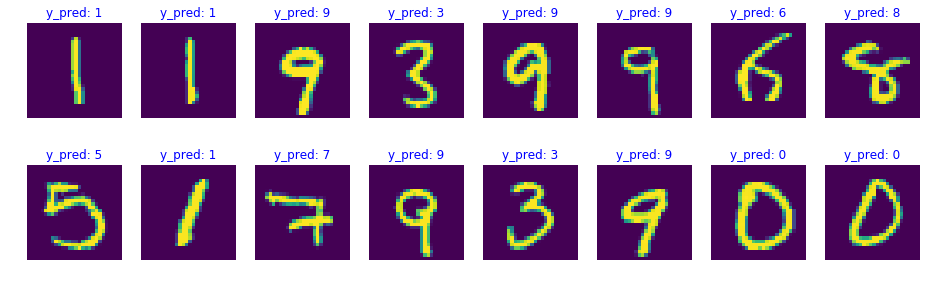

In [15]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')

### Print all feature maps

In [18]:
def print_all_feature_maps(layer, layer_name):
  """Print all feature maps
    This code is borrowed from "Deep Learning with Python" (by F. Chollet)
  
  Args:
    layer (4-rank Tensor): feature maps
    layer_name (string): name of feature maps
    
  Returns:
    print all feature maps
  """
  num_features = layer.shape[-1]
  size = int(layer.shape[1])
  images_per_row = 16
  for feature_map in range(num_features):
    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))

    for col in range(num_cols):
      for row in range(images_per_row):
        channel_image = layer[0,:,:,col * images_per_row + row]

        #channel_image -= channel_image.mean()
        channel_image -= tf.reduce_mean(channel_image)
        #channel_image /= channel_image.std()
        channel_image /= tf.keras.backend.std(channel_image)
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [19]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  print("Logits: ", model(images[10:11], training=False).shape)

Logits:  (1, 10)


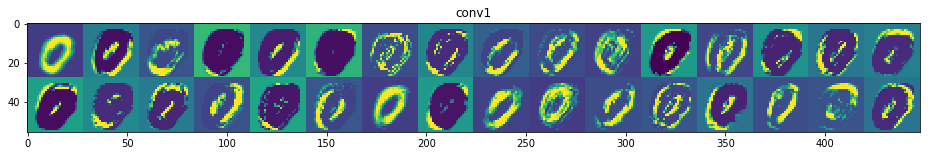

In [20]:
print_all_feature_maps(model.conv1_, 'conv1')

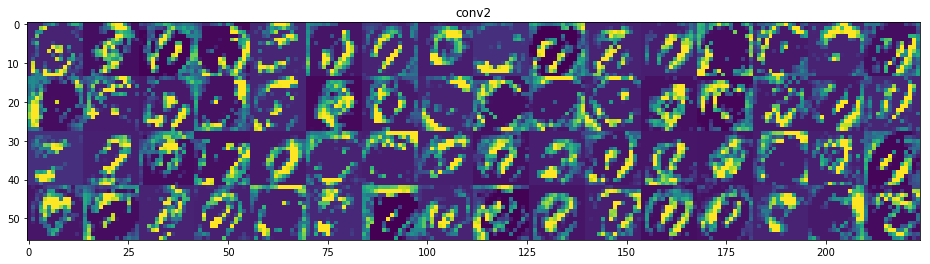

In [21]:
print_all_feature_maps(model.conv2_, 'conv2')

In [22]:
model.drop1_[0,:20]

<tf.Tensor: id=1007048, shape=(20,), dtype=float32, numpy=
array([0.08499205, 0.42951763, 0.        , 1.1591066 , 0.        ,
       0.29313603, 0.        , 0.1301806 , 0.        , 0.        ,
       0.        , 0.41188282, 0.        , 0.606058  , 0.6090672 ,
       0.4618256 , 0.        , 0.9979578 , 0.2808174 , 0.        ],
      dtype=float32)>

In [23]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  print("Logits: ", model(images[10:11], training=True).shape)

Logits:  (1, 10)


In [24]:
model.drop1_[0,:20]

<tf.Tensor: id=1007184, shape=(20,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.01204967,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00131607, 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>